# Analyzing Wildfires and Air Quality in Redding, California

## Introduction

This Jupyter Notebook aims to analyze the relationship between wildfires near Redding, California, and their potential impact on air quality. We'll explore data from wildfires and air quality to understand how these two factors are connected. 

## Data Loading

We begin by loading the necessary libraries and the data we'll use for our analysis. This includes the wildfire data and air quality data, both of which are stored in JSON files. We'll convert the data into pandas DataFrames for further analysis.

To get the std_aqi.json file you will have to execute the [AQI Analysis](./AQI_Analysis.ipynb) notebook. Whereas, the Redding_Wildfire_Features.json can be generated using [Wildfire Data Extraction](./Wildfire_Data_Extraction.ipynb) notebook.


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

## Exploring Wildfire Data
Let's take a look at the first few rows of the wildfire data to get an overview of its structure.

In [2]:
# Lets start by loading the json file we extracted from data and convert in pandas dataframe
redding_json_file = open('./Redding_Wildfire_Features.json')
redding_json_data = json.load(redding_json_file)

std_aqi_json_file = open('./std_aqi.json')
std_aqi_data = pd.DataFrame(json.load(std_aqi_json_file))

attributes_list = [item['attributes'] for item in redding_json_data]
rd_data = pd.DataFrame(attributes_list)

rd_data.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_redding
0,14317,14317,Wildfire,1963,1,"1 (1), 3 (1)",2144.285305,867.761476,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (2),...,None,None,0.409148,NaN,No,16325.442055,8.677615e+06,41.844737,-115.642656,362.128207
1,14320,14320,Wildfire,1963,1,"1 (1), 3 (2)",1799.002888,728.030639,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,None,0.425315,NaN,No,14666.428322,7.280306e+06,43.313100,-113.708213,485.036852
2,14341,14341,Wildfire,1963,1,"1 (2), 3 (2)",647.246513,261.931371,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (4),...,None,None,0.272200,NaN,No,10996.509615,2.619314e+06,43.526885,-103.471801,991.766468
3,14319,14319,Wildfire,1963,1,"1 (2), 3 (3)",1895.001227,766.879789,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (4), Likely Wildfire (1)",...,None,None,0.733421,NaN,No,11462.834247,7.668798e+06,38.281675,-122.148482,159.533440
4,14308,14308,Wildfire,1963,1,"1 (1), 3 (2)",4293.410613,1737.481631,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (2)",...,None,None,0.344648,NaN,No,25169.664017,1.737482e+07,43.168668,-113.283987,502.100420


## Exploring Air Quality Data
Similarly, we'll examine the air quality data to understand its contents.

In [3]:
std_aqi_data.head()

,Year,Calculated AQI
0,1972,82.2
1,1973,83.0
2,1974,90.6
3,1975,64.6
4,1979,174.8


# Analyzing Wildfires
## Descriptive Statistics
We start by performing a summary analysis of the wildfire data. This includes statistics such as mean, minimum, and maximum values for various attributes. In particular, we are interested in the "GIS_Acres" column as it might help estimate the air quality.

In [4]:
# Lets look at the mean, min and max of GIS_Acres which might help us in estimating the air quality
rd_data.describe()

,OBJECTID,USGS_Assigned_ID,Fire_Year,Fire_Polygon_Tier,GIS_Acres,GIS_Hectares,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,fire_lat,fire_lon,distance_from_redding
count,75240.000000,75240.000000,75240.000000,75240.000000,7.524000e+04,75240.000000,75240.000000,6204.0,7.524000e+04,7.524000e+04,75240.000000,75240.000000,75240.000000
mean,69719.773179,69719.773179,2000.880821,2.821784,1.850366e+03,748.816644,0.480549,1.0,1.000741e+04,7.488166e+06,40.736436,-115.565605,485.962842
std,36401.183212,36401.183212,14.743075,2.706777,1.376059e+04,5568.713006,0.260187,0.0,3.151719e+04,5.568713e+07,4.344264,6.042153,287.929559
min,14299.000000,14299.000000,1963.000000,1.000000,4.697010e-06,0.000002,0.000051,1.0,6.295036e-01,1.900813e-02,29.953001,-132.604003,2.252244
25%,38700.750000,38700.750000,1989.000000,1.000000,1.576635e+01,6.380415,0.274056,1.0,1.267595e+03,6.380415e+04,37.530380,-120.359751,246.340618
50%,64078.500000,64078.500000,2005.000000,1.000000,7.975534e+01,32.275840,0.446541,1.0,3.254998e+03,3.227584e+05,41.754136,-116.894567,445.818606
75%,99211.250000,99211.250000,2013.000000,6.000000,5.049323e+02,204.338847,0.653013,1.0,8.929961e+03,2.043388e+06,43.883444,-111.528494,678.154834
max,135061.000000,135061.000000,2020.000000,8.000000,1.032651e+06,417899.203637,0.997980,1.0,2.899586e+06,4.178992e+09,55.680651,-98.360109,1249.956972


## Wildfires by Distance
Next, we analyze the distribution of wildfires concerning their distance from Redding, California. We create a histogram that shows the number of wildfires at 50-mile intervals from Redding.

Text(0.5, 1.0, 'Number of wildfires every 50 miles from Redding, California')

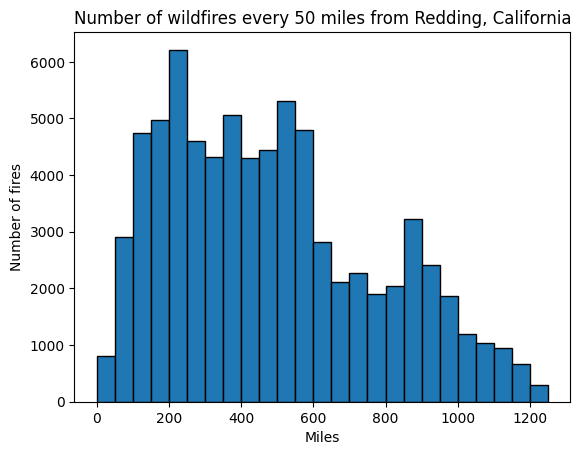

In [19]:
distances = []

for index, row in rd_data.iterrows():
    distance_str = row['distance_from_redding']
    distance_float = float(distance_str)
    distances.append(distance_float)

bins = np.linspace(0, 1250, ((1250) // 50)+1)

#Create plot
plt.hist(distances, bins, edgecolor='black')
plt.xlabel("Miles")
plt.ylabel("Number of fires")
plt.title("Number of wildfires every 50 miles from Redding, California")

## Area Burned Over Time
We further investigate the wildfires by analyzing the area burned over the years. This will give us insights into the scale and impact of wildfires over time.

In [6]:
area_burned = {}
for index, row in rd_data.iterrows():
    year = row['Fire_Year']
    area = row['GIS_Acres']
    if year in area_burned:
        area_burned[year]+=area
    else:
        area_burned[year]=area

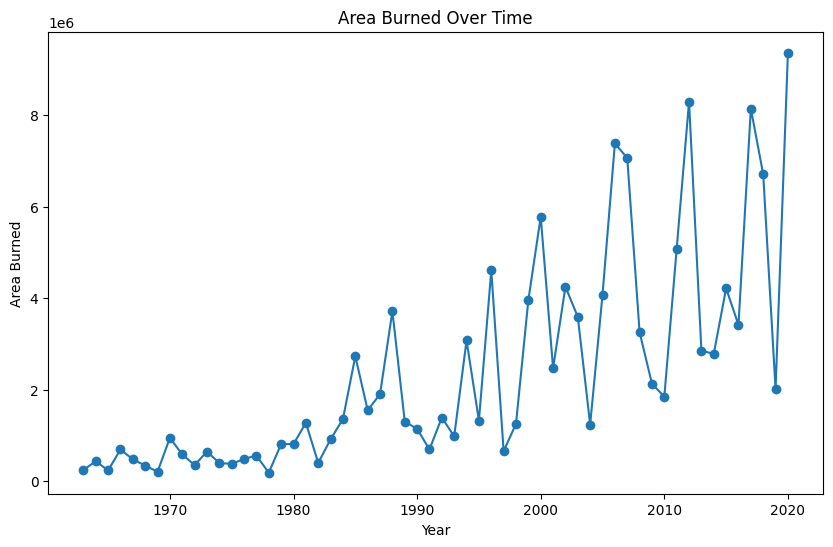

In [7]:
# Extract years and corresponding values
years = list(area_burned.keys())
values = list(area_burned.values())

# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(years, values, marker='o', linestyle='-')
plt.title('Area Burned Over Time')
plt.xlabel('Year')
plt.ylabel('Area Burned')

# Show the plot
plt.show()

## Estimating Fire Smoke
We are particularly interested in understanding the potential effect of wildfires on air quality. We'll calculate an estimated fire smoke based on the distance from Redding and the area burned. This will allow us to visualize the estimated smoke over the years.

### Logic behind estimation
We are taking the max distance i.e. 1250 miles for each fire to convert into a range of 0-1, where o being the farthest from Redding and 1 being the closest. We are using this distance to penalize the overall score. Another factor that might affect the fire is the Hectares burnt. For hectares burnt, we can see from the descriptive statistics that there is a hughe difference between the mean and 50% of the distribution. In order to accomodate for this extreme ended values, we are using the value at 75% distribution which is 204.

In [8]:
# We are only interested in the area burnt and the distance from the Redding. 
# Based on these we will create a new dataframe having year wise estimated fire smoke.

rd_data['es_aqi'] = (1 - rd_data['distance_from_redding'] / 1250) * (204 - rd_data['GIS_Hectares'] / 204) 
average_aqi_by_year = rd_data.groupby('Fire_Year')['es_aqi'].mean()

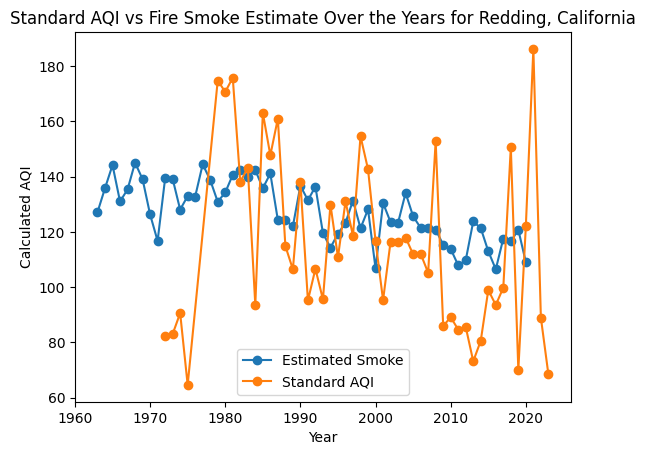

In [21]:
plt.plot(average_aqi_by_year.index, average_aqi_by_year.values, label='Estimated Smoke', marker='o')

# Plot data from 1972
plt.plot(std_aqi_data['Year'], std_aqi_data['Calculated AQI'], label='Standard AQI', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Calculated AQI')
plt.title('Standard AQI vs Fire Smoke Estimate Over the Years for Redding, California')

# Add a legend to distinguish between the two datasets
plt.legend()

# Show the plot
plt.show()


## Time Series Analysis
Since the data we have is a time-series data, we can use time-series algorithms to forecast future values till 2049.
To analyze the time series data, we'll use the AutoARIMA algorithm to determine the best (p, d, q) order for the ARIMA model. We'll also fit an ARIMA model and make predictions.

In [10]:
# Load the data
data = pd.Series(average_aqi_by_year)  

model = auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True, 
                   error_action="ignore", max_order=None, trace=True, information_criterion='bic')

# Get the best order (p, d, q) determined by auto_arima
best_order = model.get_params()['order']

print("Best (p, d, q) order:", best_order)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=422.632, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=420.242, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=406.818, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=418.657, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=405.627, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=408.464, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=408.238, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=416.324, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=412.279, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.718 seconds
Best (p, d, q) order: (0, 1, 1)


In [16]:
# Fit ARIMA model
model = ARIMA(data, order=(4, 2, 2)) 
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=28)
predictions_data = pd.DataFrame({'Year': range(2021, 2049), 'Predictions': predictions})

print("AIC : "+str(model_fit.aic)+" BIC : "+str(model_fit.bic))

/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC : 404.4962400461253 BIC : 418.67370188127137


/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


By using Auto-arima, we got values like 0,1,1 which did yeild a lower aic and bic value but did not do a good job while forecasting. With trial and error we found that 4,2,2 values work the best for p,d and q parameters respectively

## Estimated vs. Predicted Data
Finally, we compare the actual data with the predictions to visualize how well our model performs.

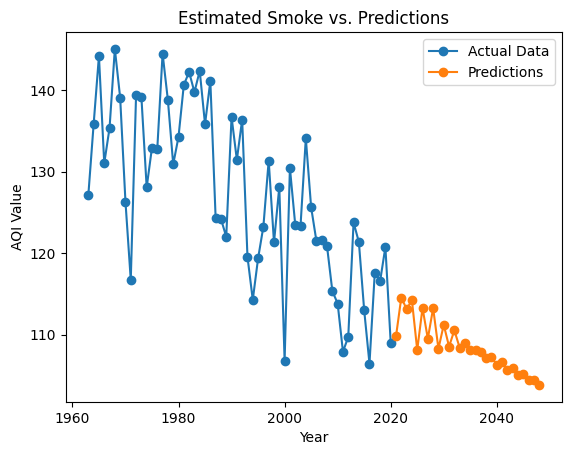

In [23]:
# Plot the actual data
plt.plot(average_aqi_by_year.index, average_aqi_by_year.values, label='Actual Data', marker='o', markersize=6)

# # Plot the predictions
plt.plot(predictions_data['Year'], predictions_data['Predictions'], label='Predictions', marker='o', markersize=6)


# Set plot labels and legend
plt.xlabel('Year')
plt.ylabel('AQI Value')
plt.title('Estimated Smoke vs. Predictions')
plt.legend()

# Show the plot
plt.show()

In this analysis, we explored the relationship between wildfires near Redding, California, and their potential impact on air quality, providing insights into the patterns and trends over the years. Although, the estimation will have certain level of uncertainity. There are numerous reasons to this uncertainity:
1. The smoke estimate itself is based on just two factors. It does not take into account many other factors like, type of wood or material which was burnt, geography of that area, wind information.
2. The number of data points are very less.
3. AQI values are predicted for each day, generalizing for a whole year might not reflect the analysis correctly.